# Ghosts beam test
This notebook shows the different sets of ghosts obtained for different incident beams, in particular testing high angles

## TODO
- move `beam_test` to a module: `simulator`, `analysis` or `plotter`... or other

In [1]:
%load_ext autoreload
%autoreload 


In [2]:
import timeit
import copy
import concurrent.futures 
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import batoid

from ghosts import plotter
from ghosts import simulator
from ghosts import tweak_optics
from ghosts import beam
from ghosts import geom


from ghosts.analysis import compute_ghost_separations, reduce_ghosts
from ghosts.analysis import match_ghosts, compute_reduced_distance, compute_2d_reduced_distance, find_nearest_ghost
from ghosts.analysis import make_data_frame

from ghosts.beam_configs import BEAM_CONFIG_0, BEAM_CONFIG_1, BEAM_CONFIG_3
from ghosts.geom_configs import GEOM_CONFIG_0


In [3]:
from ghosts.constants import *
print(f'LSST Camera has {LSST_CAMERA_PIXEL_DENSITY_MM2:.0f} pixels per mm^2')

LSST Camera has 9000 pixels per mm^2


Direct path is number 15
  central impact point is (0.099719, 0.000010)
  transmission is 0.7530

Maximum expected flux is 0.7530
Maximum bin content is 519.1716


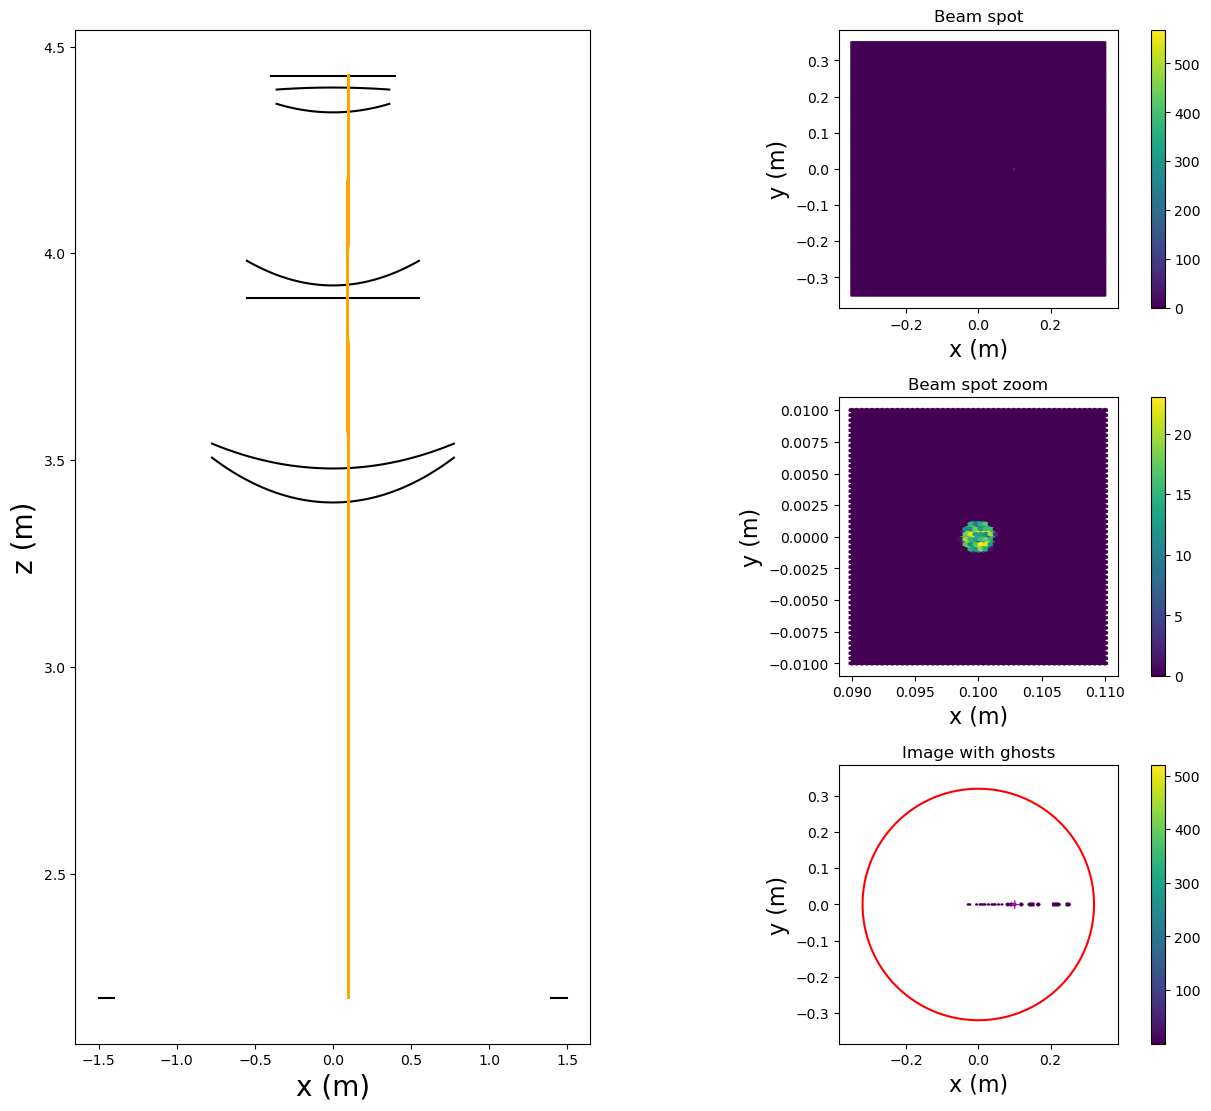

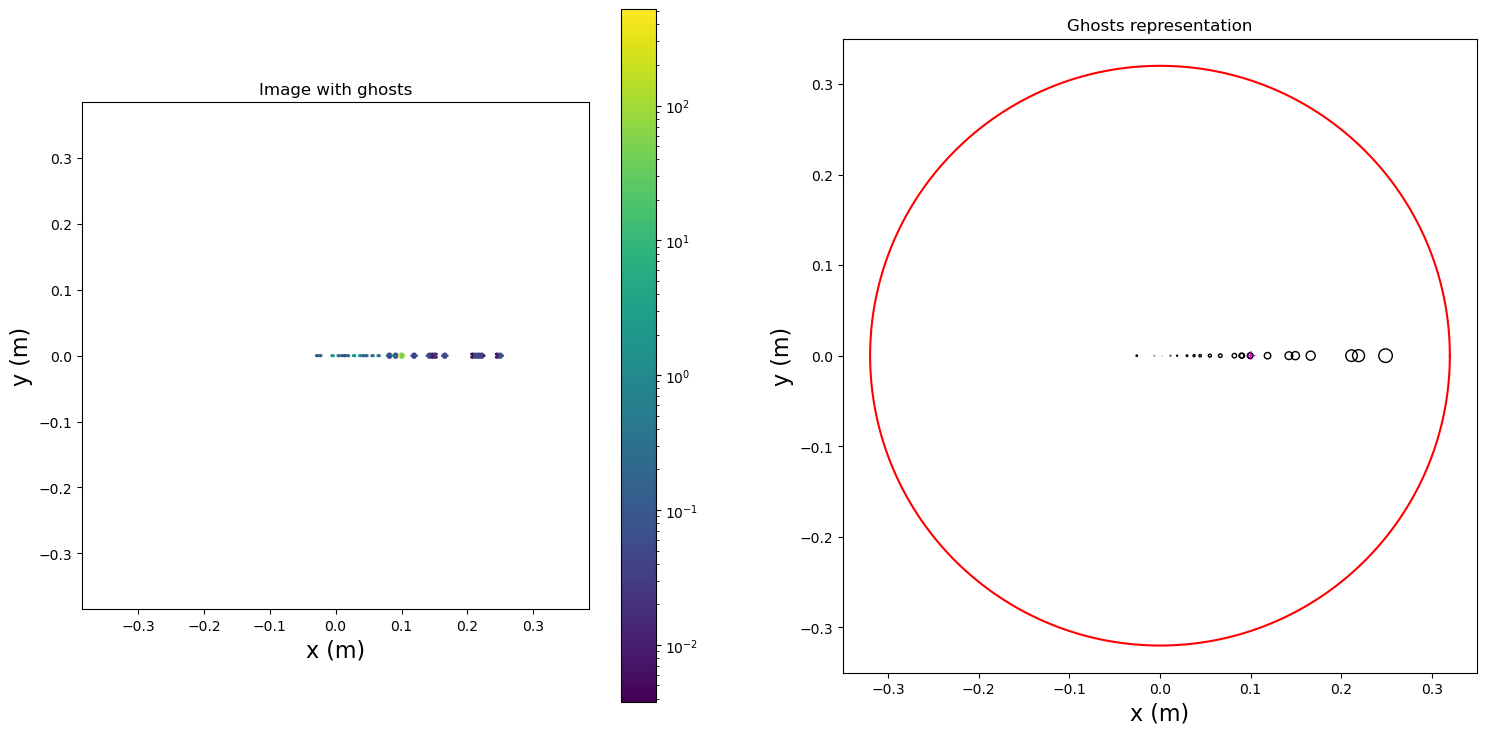

In [4]:
# Second CCOB like geometry, i.e. lenses + filters
telescope = batoid.Optic.fromYaml("../data/LSST_CCOB_r.yaml")

# Make refractive interfaces partially reflective
tweak_optics.make_optics_reflective(telescope, coating='smart', r_frac=[0.02, 0.02, 0.15])

# Run simulation with standard beam config
trace_full, r_forward, r_reverse, rays = simulator.run_simulation(telescope, beam_config=BEAM_CONFIG_1)
simulation = [trace_full, r_forward, r_reverse, rays]
# Check setup
plotter.plot_setup(telescope, simulation)

# camera and ghosts visualization
spots_data, _spots = reduce_ghosts(r_forward)
data_frame = make_data_frame(spots_data)
_fig, _ax = plotter.plot_full_camera_and_spots(r_forward, data_frame, log_scale=True)

In [5]:
def beam_test(telescope, beam_config):
    # Run simulation with standard beam config
    trace_full, r_forward, r_reverse, rays = simulator.run_simulation(telescope, beam_config=beam_config)
    simulation = [trace_full, r_forward, r_reverse, rays]
    # Check setup
    plotter.plot_setup(telescope, simulation)

    # camera and ghosts visualization
    spots_data, _spots = reduce_ghosts(r_forward)
    data_frame = make_data_frame(spots_data)
    _fig, _ax = plotter.plot_full_camera_and_spots(r_forward, data_frame, log_scale=True)

Direct path is number 10
  central impact point is (0.129945, 0.184218)
  transmission is 0.7530

Maximum expected flux is 0.7530
Maximum bin content is 554.1830


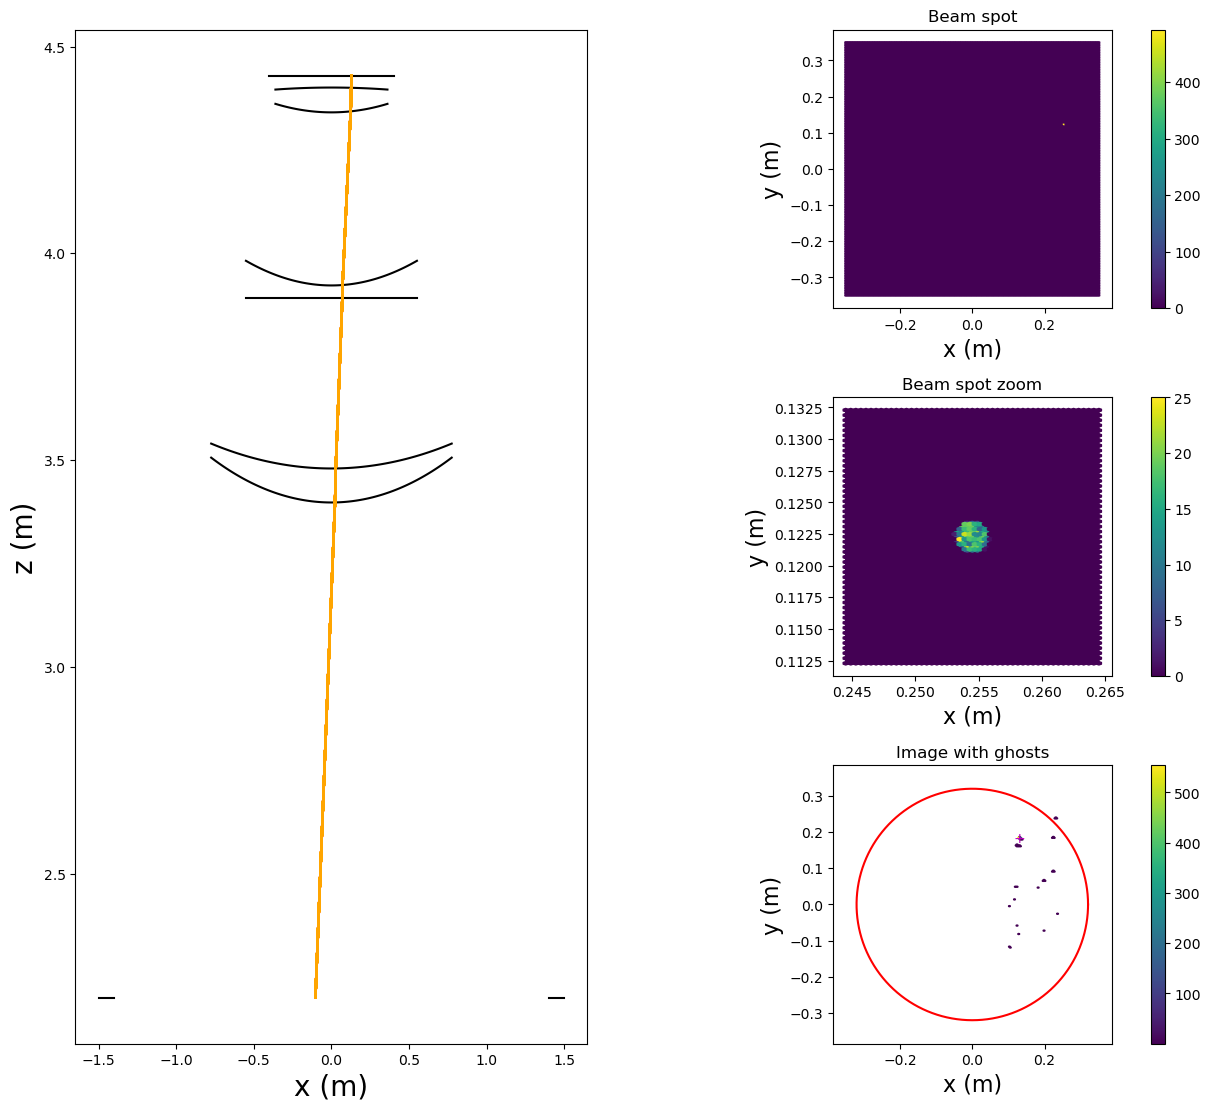

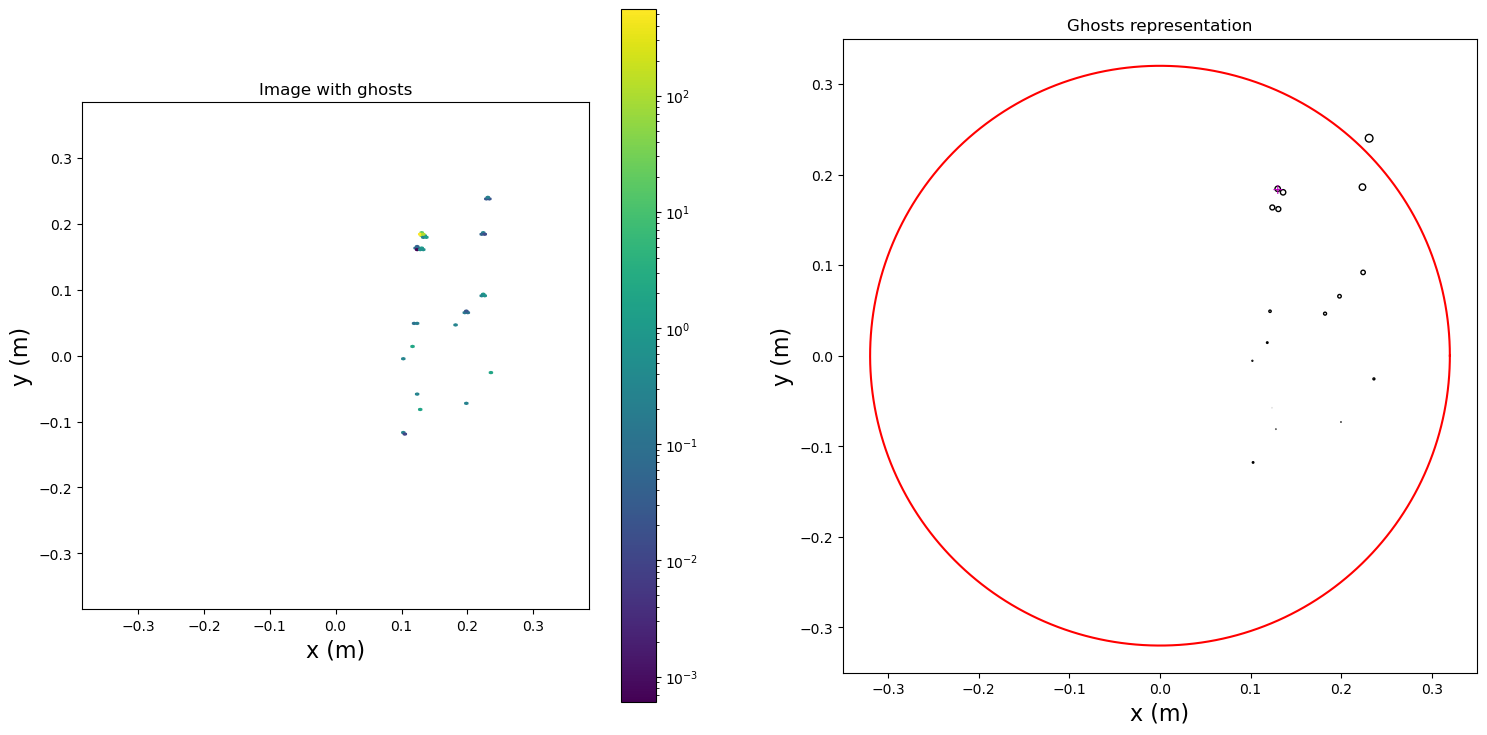

In [6]:
# Test beam - asymmetric, small angles, all ghosts inside
new_beam = copy.deepcopy(BEAM_CONFIG_0)
new_beam['x_offset'] = -0.1
new_beam['y_offset'] = 0.3

new_beam['x_euler'] = 3
new_beam['y_euler'] = 6

beam_test(telescope, new_beam)

Direct path is number 7
  central impact point is (-0.069690, -0.073764)
  transmission is 0.7530

Maximum expected flux is 0.7530
Maximum bin content is 543.6415


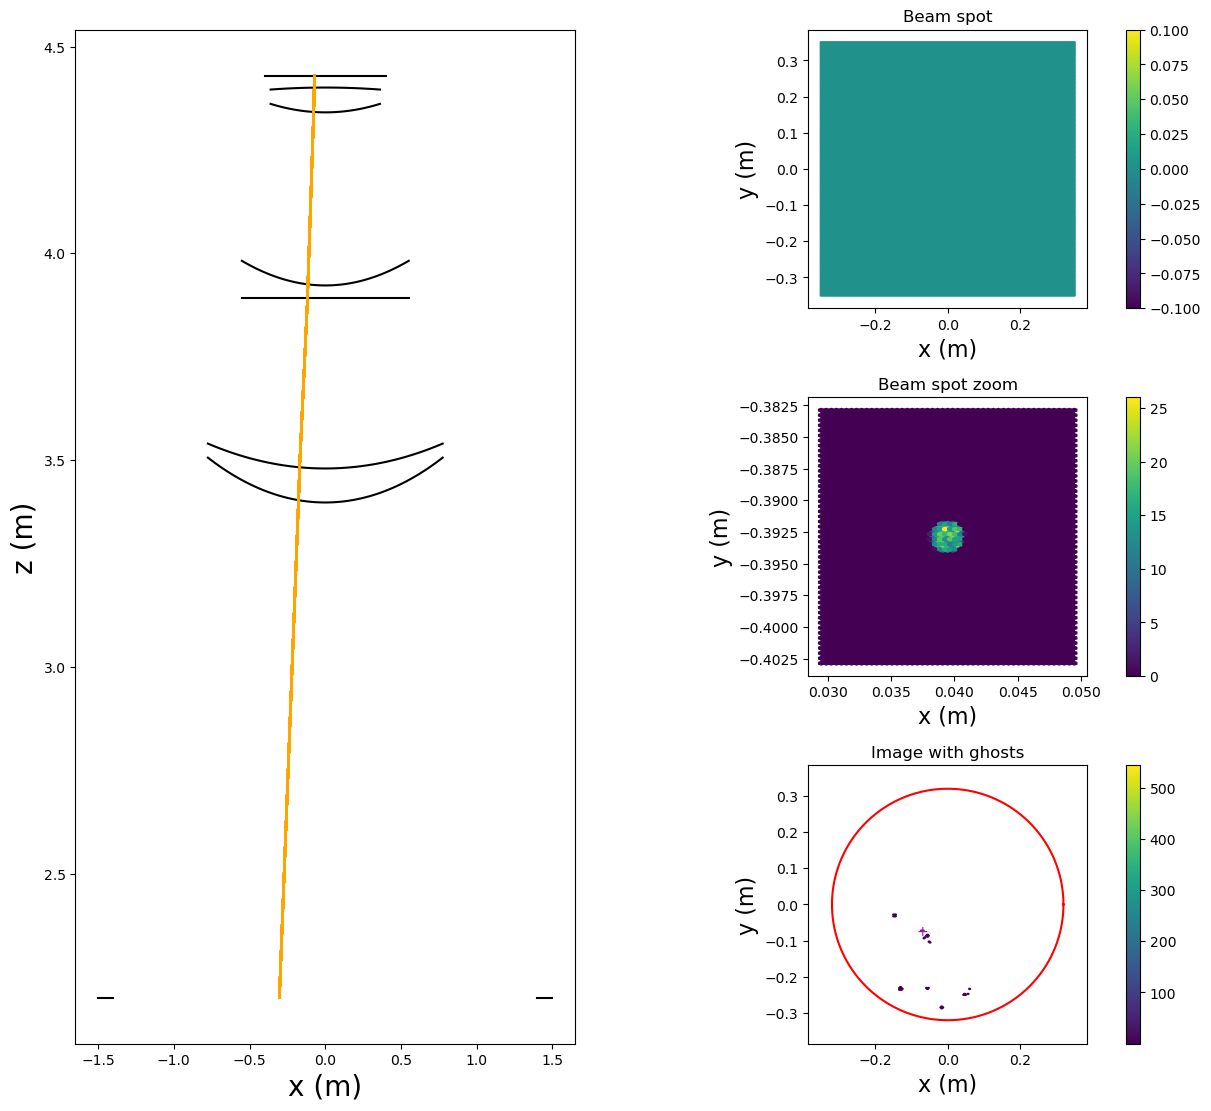

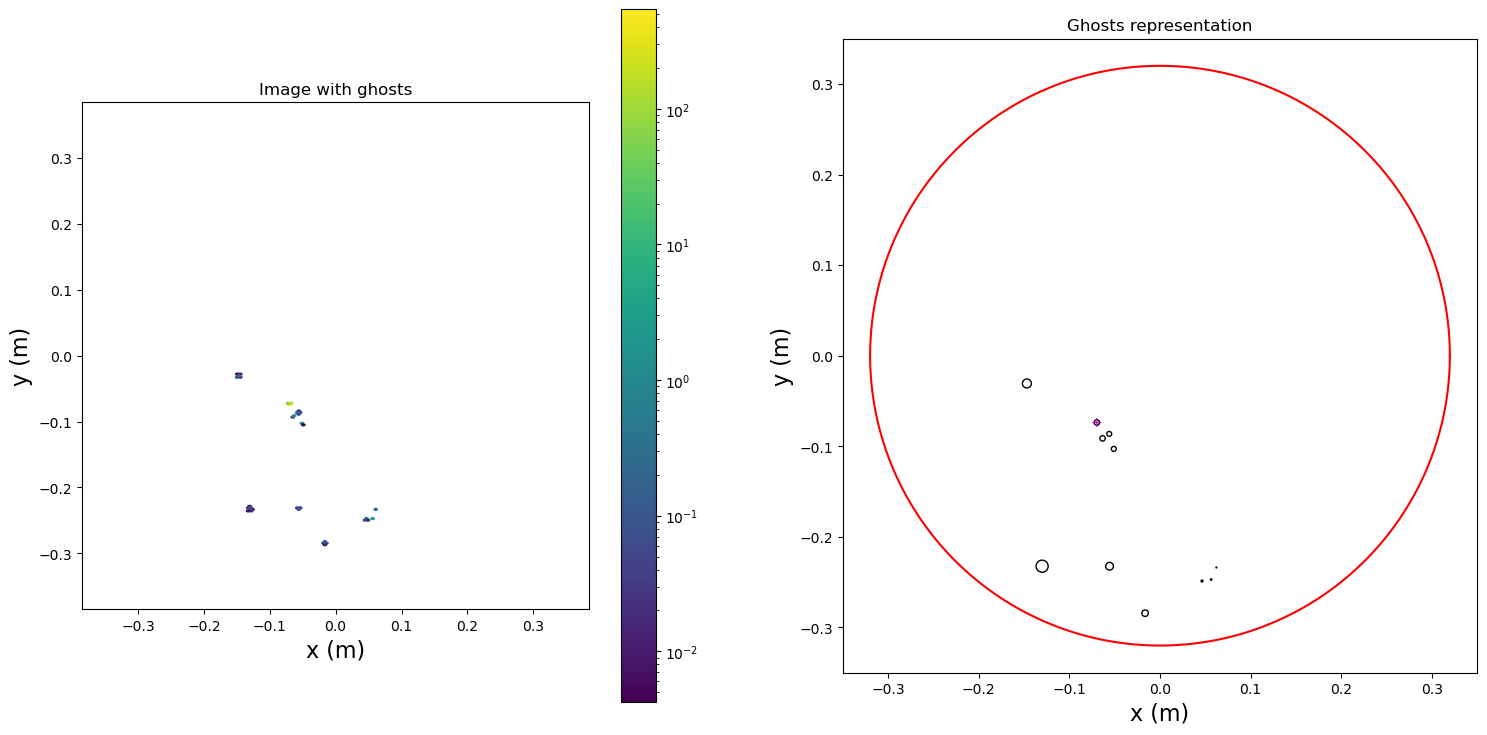

In [7]:
# Test beam - asymmetric, high angles, all ghosts inside
new_beam = copy.deepcopy(BEAM_CONFIG_0)
new_beam['x_offset'] = -0.3
new_beam['y_offset'] = 0.6

new_beam['x_euler'] = 17
new_beam['y_euler'] = 6

beam_test(telescope, new_beam)

Direct path is number 8
  central impact point is (-0.131113, 0.100431)
  transmission is 0.7530

Maximum expected flux is 0.7530
Maximum bin content is 459.3093


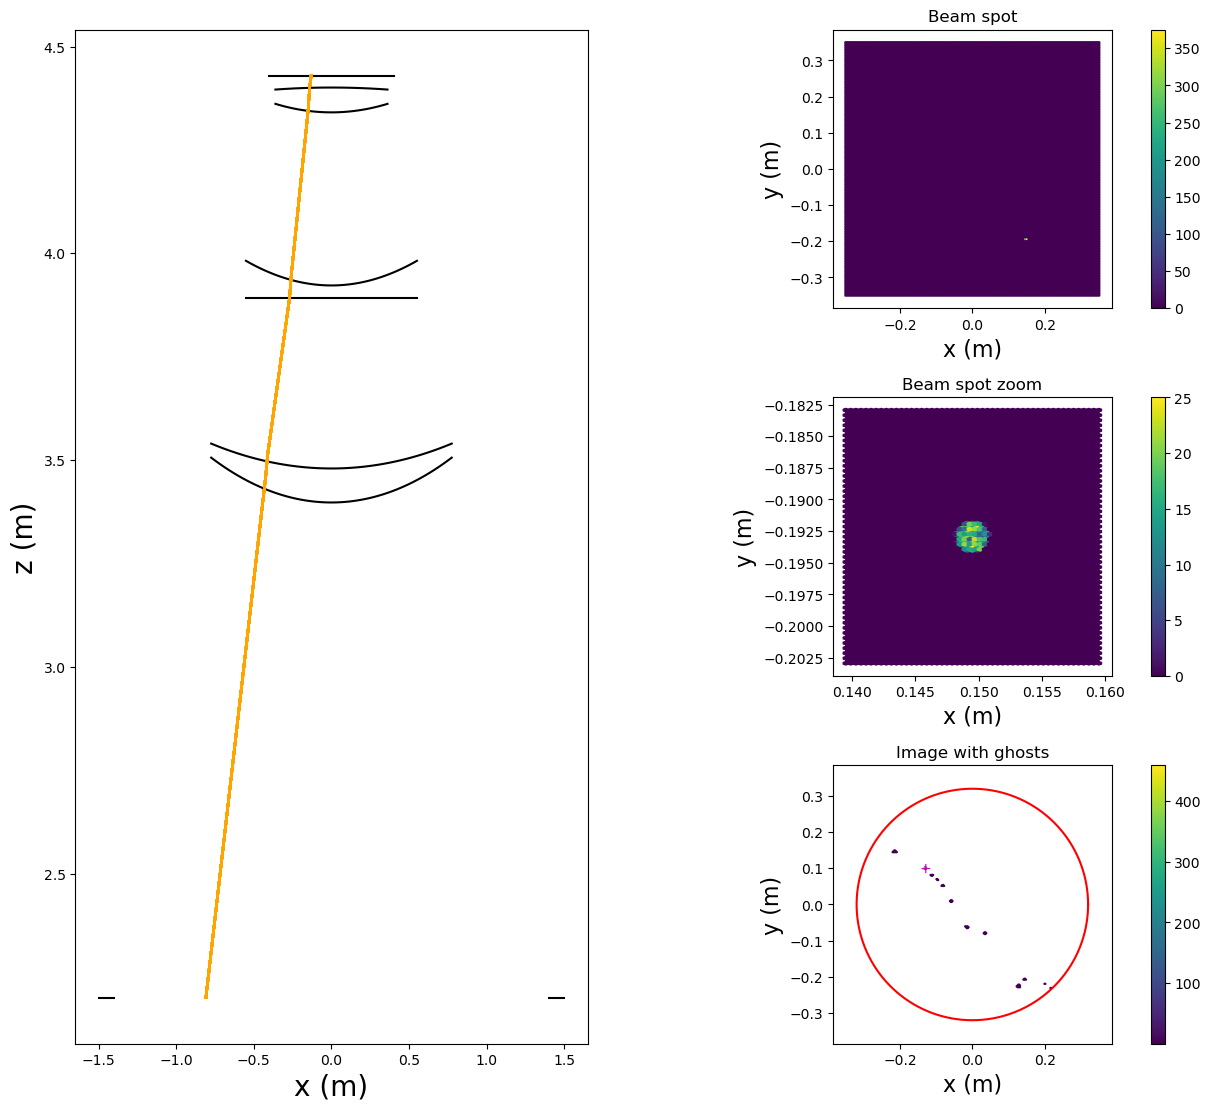

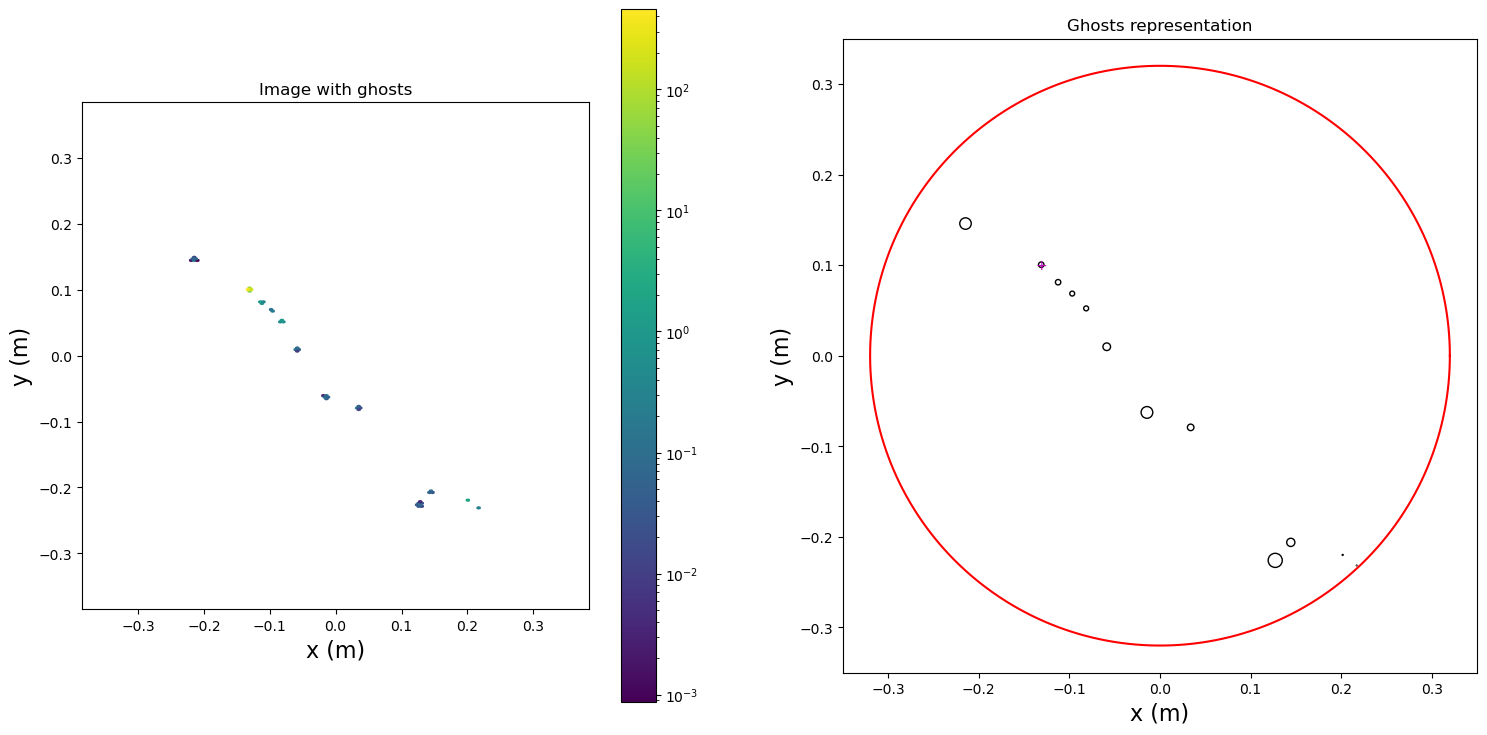

In [8]:
# Test beam - symmetric, high angles but all ghosts inside
new_beam = copy.deepcopy(BEAM_CONFIG_0)
new_beam['x_offset'] = -0.8
new_beam['y_offset'] = 0.8

new_beam['x_euler'] = 17
new_beam['y_euler'] = 17

beam_test(telescope, new_beam)

Direct path is number 4
  central impact point is (-0.004514, -0.011705)
  transmission is 0.7530

Maximum expected flux is 0.7530
Maximum bin content is 353.8940


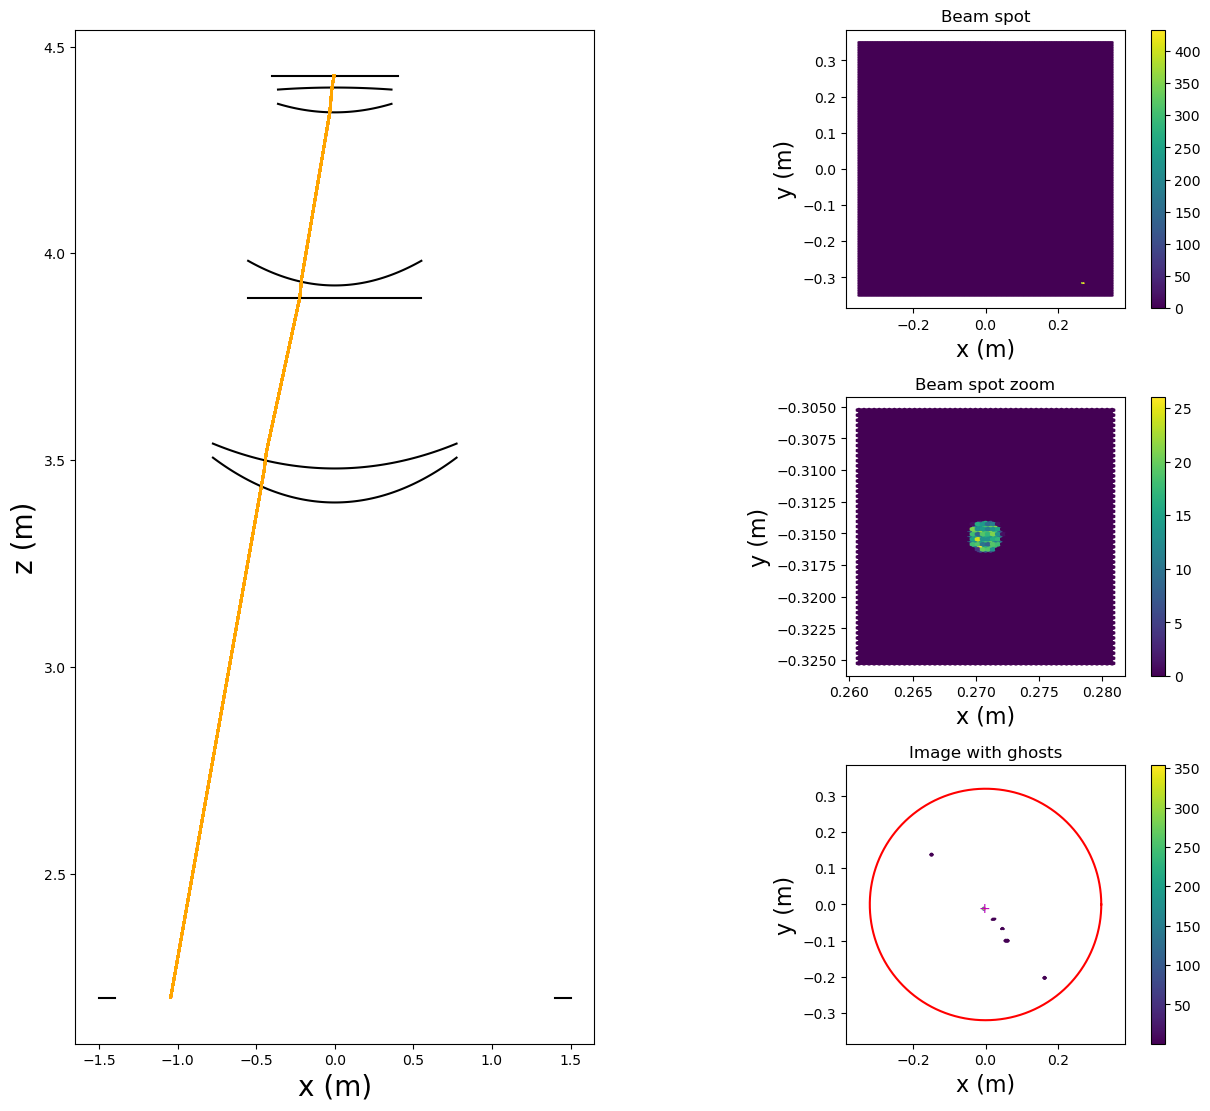

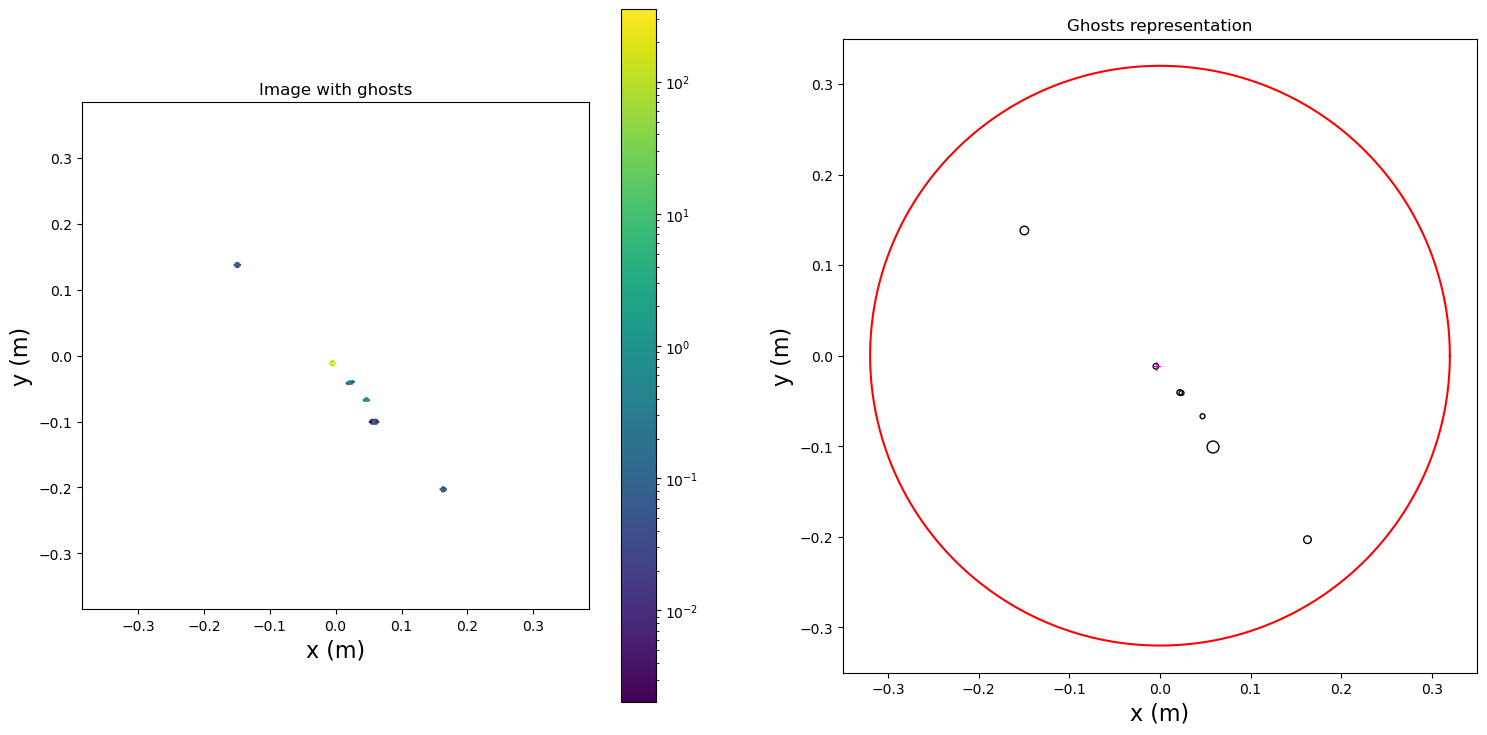

In [9]:
# Test beam - camera center !
new_beam = copy.deepcopy(BEAM_CONFIG_0)
new_beam['x_offset'] = -1.03
new_beam['y_offset'] = 1.12

new_beam['x_euler'] = 25
new_beam['y_euler'] = 25

beam_test(telescope, new_beam)

## Testing 4 symmetrical configurations

Direct path is number 7
  central impact point is (-0.069719, -0.073797)
  transmission is 0.7530

Maximum expected flux is 0.7530
Maximum bin content is 549.6652


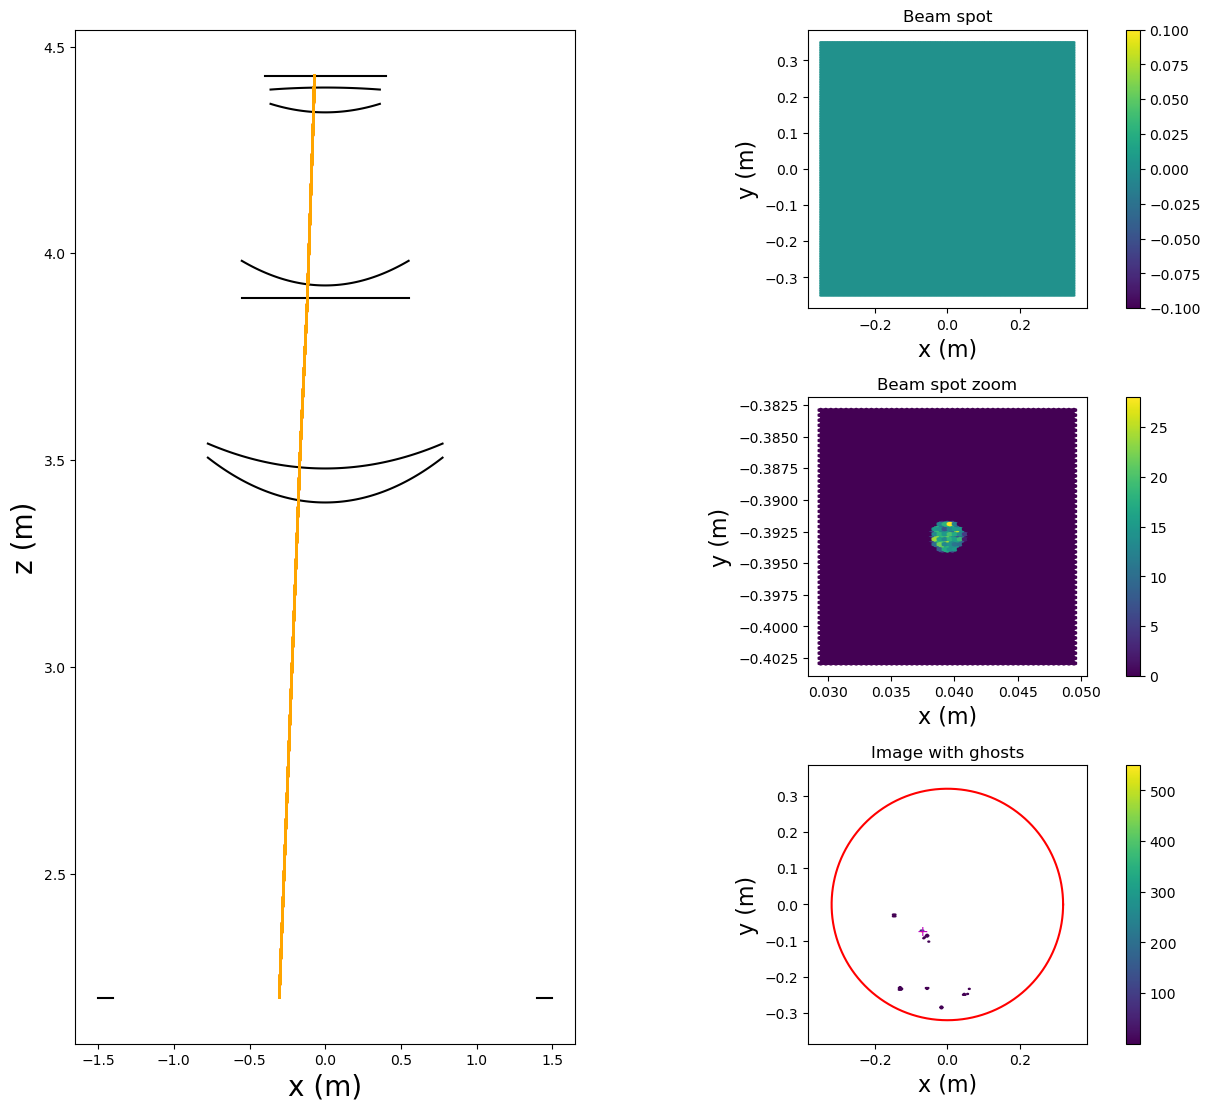

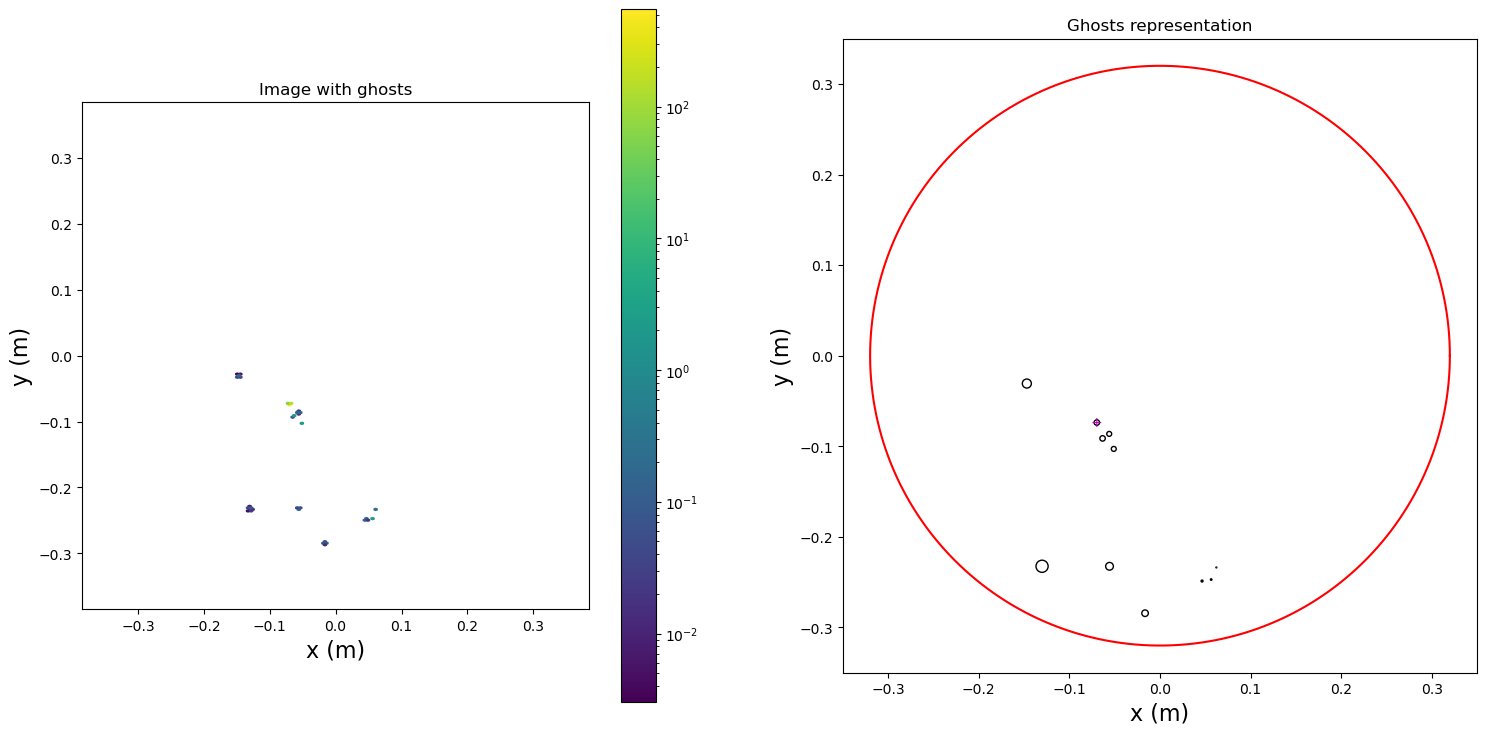

In [10]:
# Test beam - asymmetric, high angles, all ghosts inside
new_beam = copy.deepcopy(BEAM_CONFIG_0)
new_beam['x_offset'] = -0.3
new_beam['y_offset'] = 0.6

new_beam['x_euler'] = 17
new_beam['y_euler'] = 6

beam_test(telescope, new_beam)

Direct path is number 7
  central impact point is (0.069659, -0.073793)
  transmission is 0.7530

Maximum expected flux is 0.7530
Maximum bin content is 542.8885


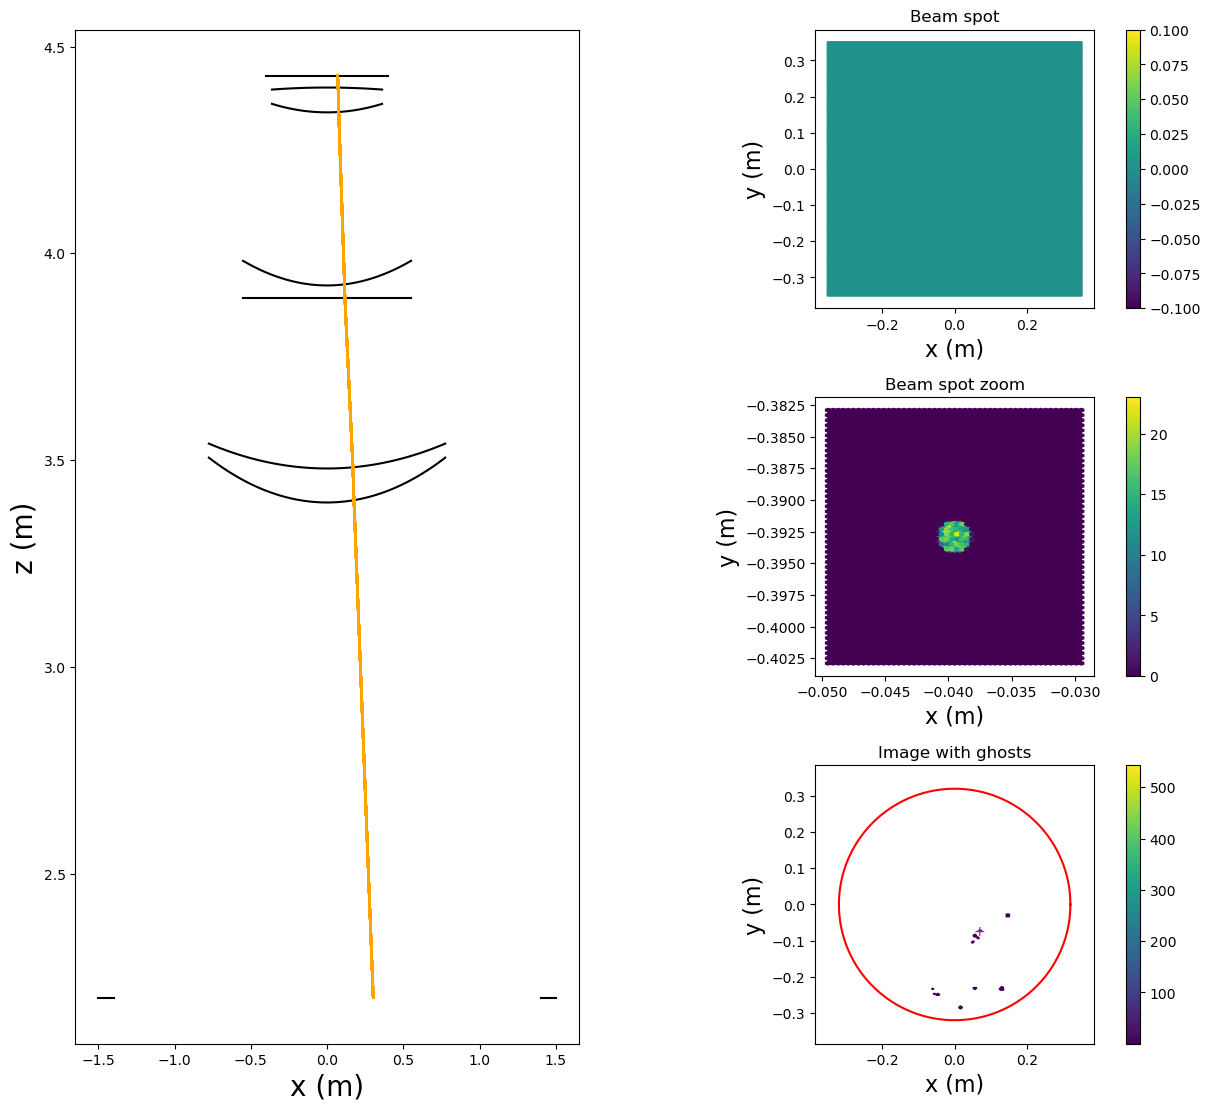

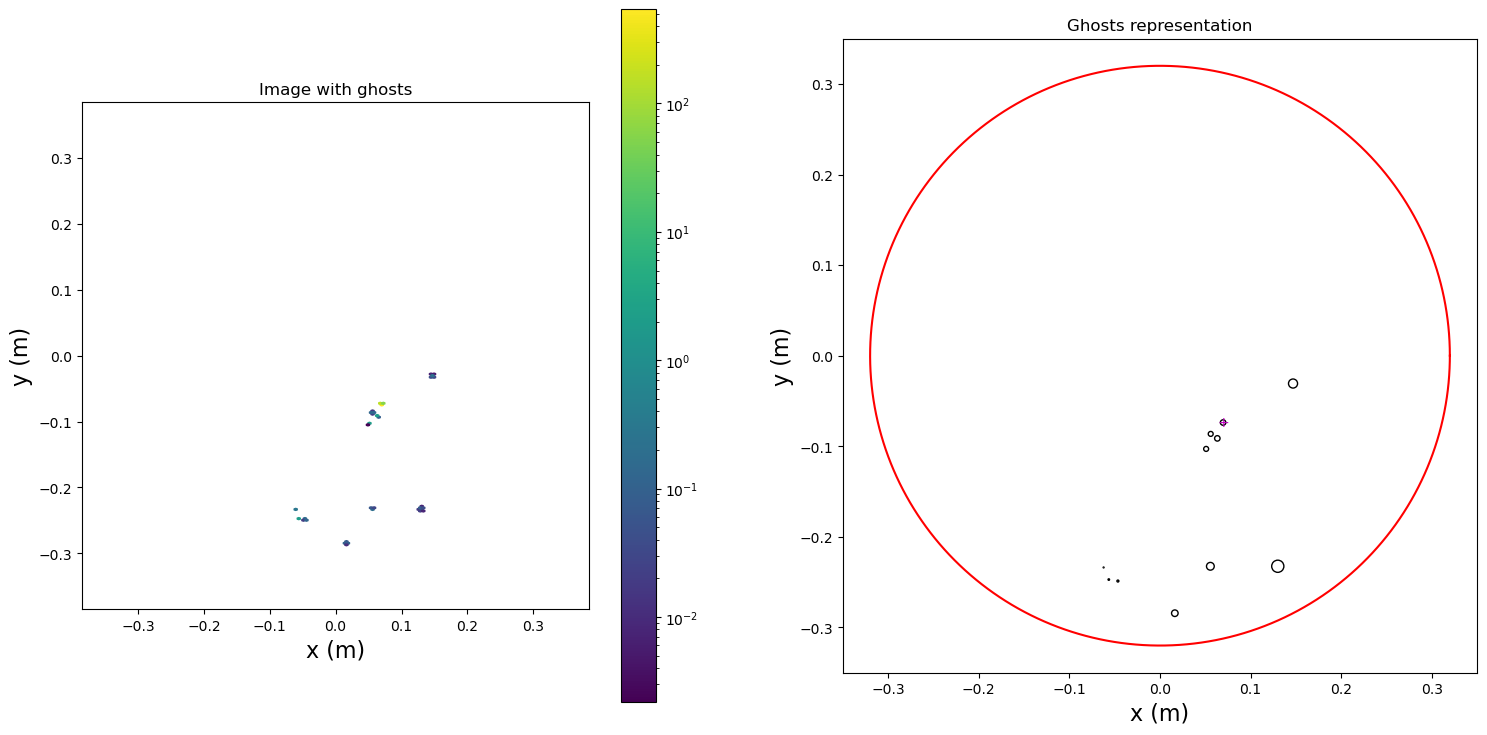

In [11]:
# Test beam - asymmetric, high angles, all ghosts inside
new_beam = copy.deepcopy(BEAM_CONFIG_0)
new_beam['x_offset'] = +0.3
new_beam['y_offset'] = 0.6

new_beam['x_euler'] = 17
new_beam['y_euler'] = -6

beam_test(telescope, new_beam)

Direct path is number 7
  central impact point is (0.069696, 0.073803)
  transmission is 0.7530

Maximum expected flux is 0.7530
Maximum bin content is 542.8885


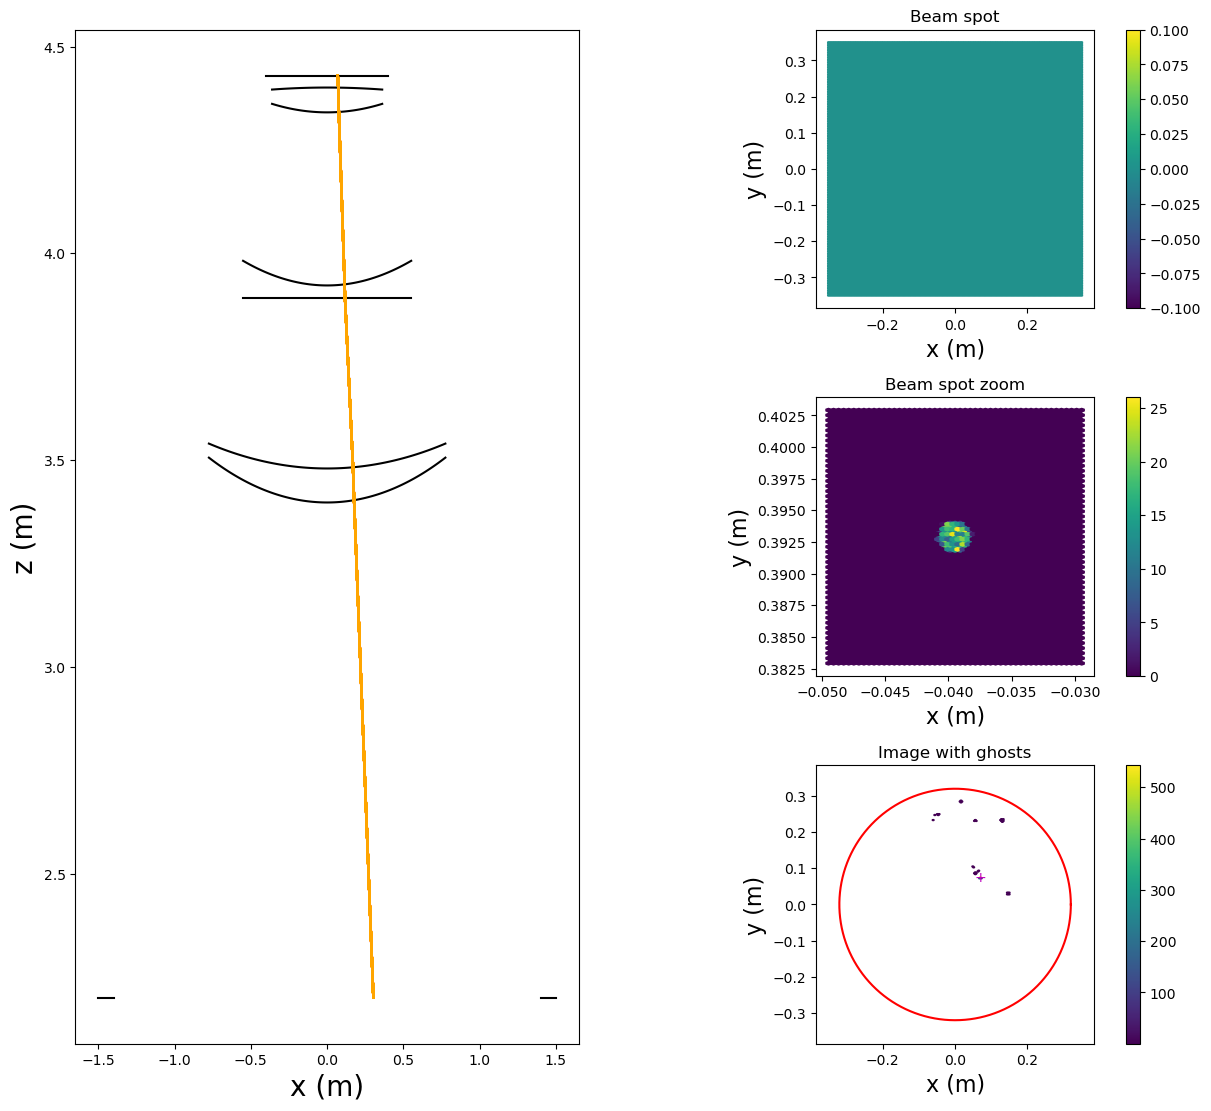

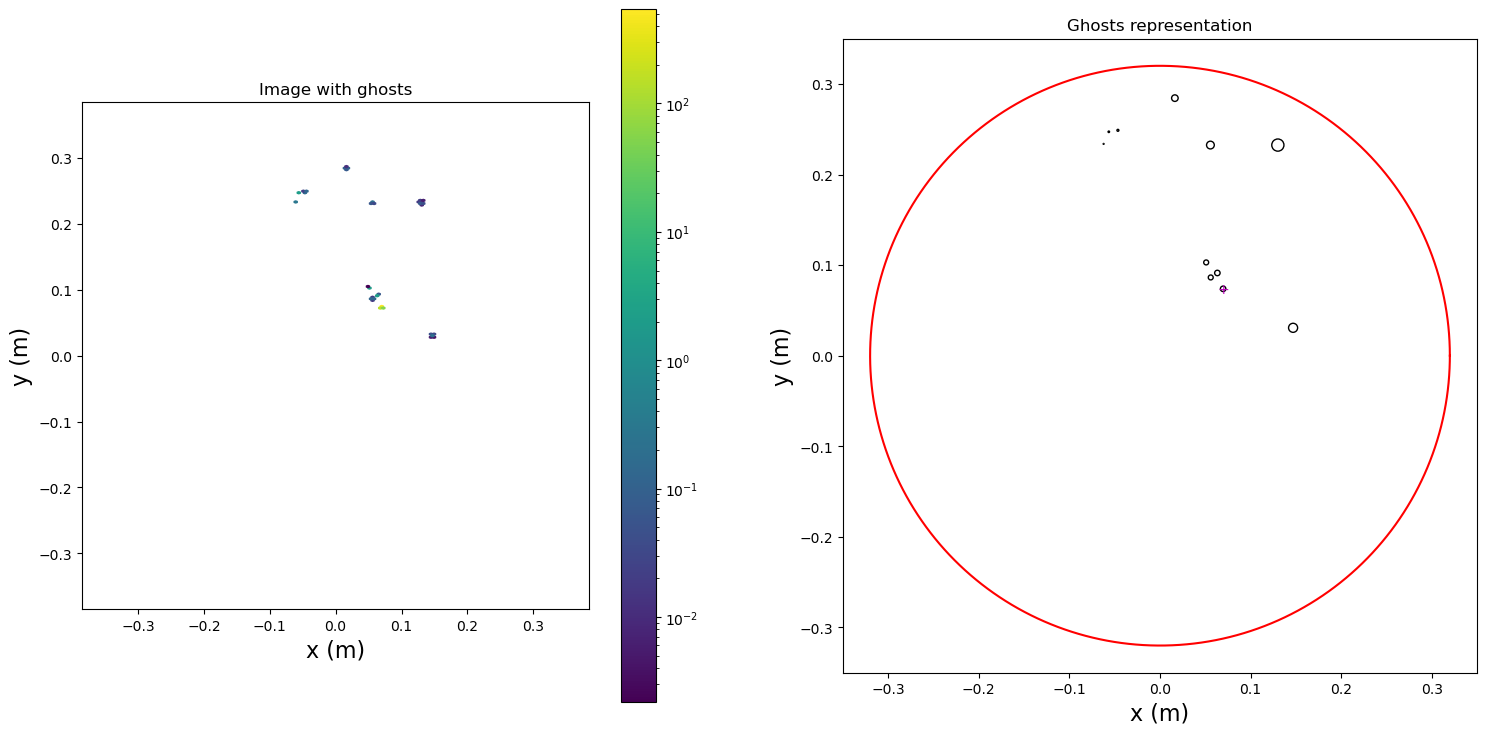

In [12]:
# Test beam - asymmetric, high angles, all ghosts inside
new_beam = copy.deepcopy(BEAM_CONFIG_0)
new_beam['x_offset'] = +0.3
new_beam['y_offset'] = -0.6

new_beam['x_euler'] = -17
new_beam['y_euler'] = -6

beam_test(telescope, new_beam)

Direct path is number 7
  central impact point is (-0.069710, 0.073764)
  transmission is 0.7530

Maximum expected flux is 0.7530
Maximum bin content is 551.1711


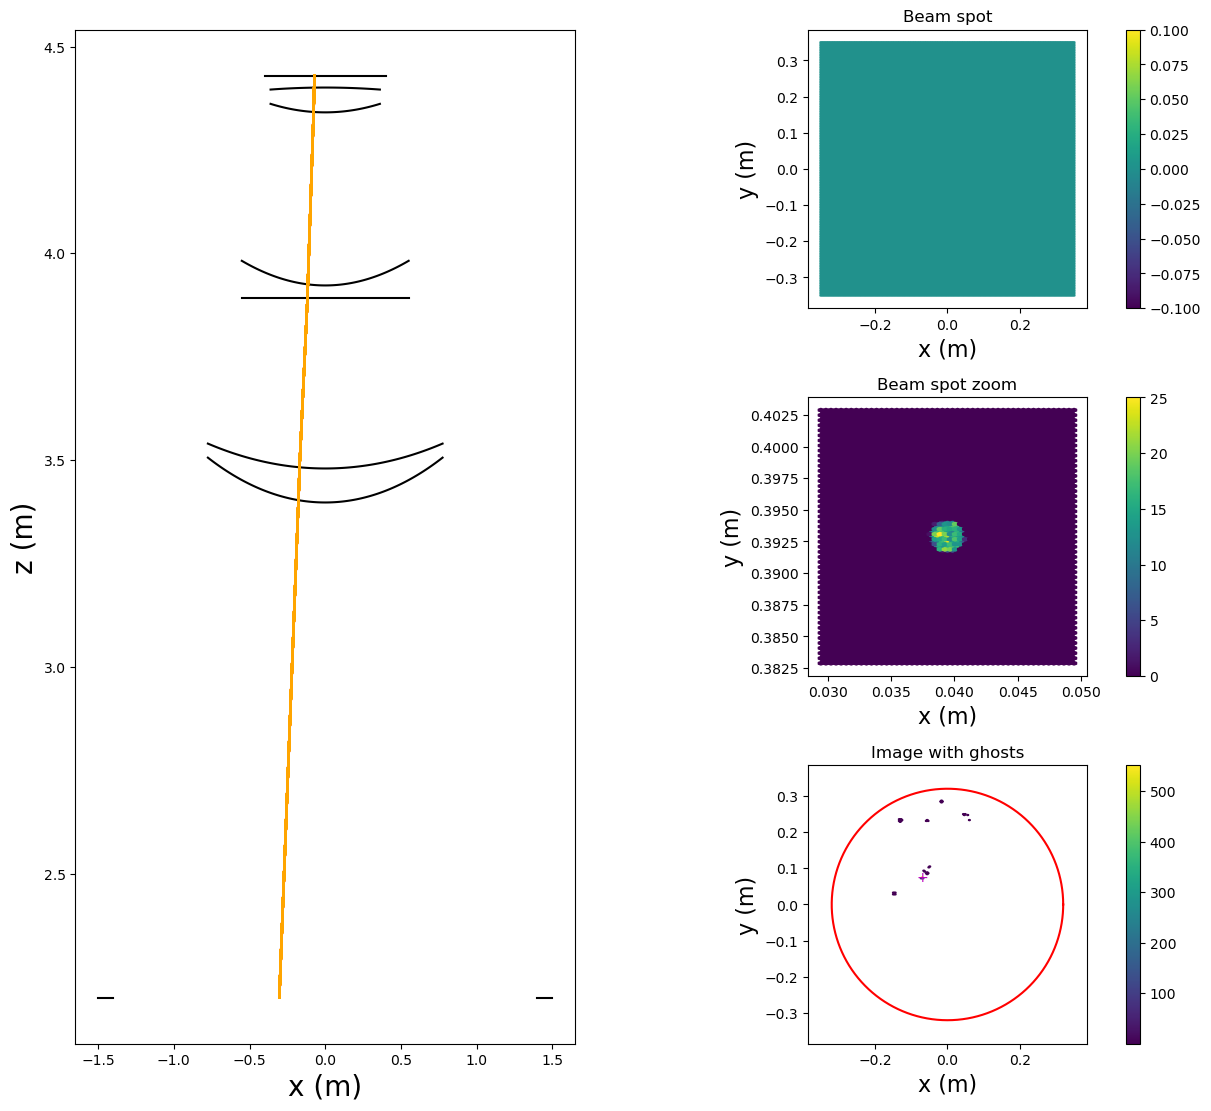

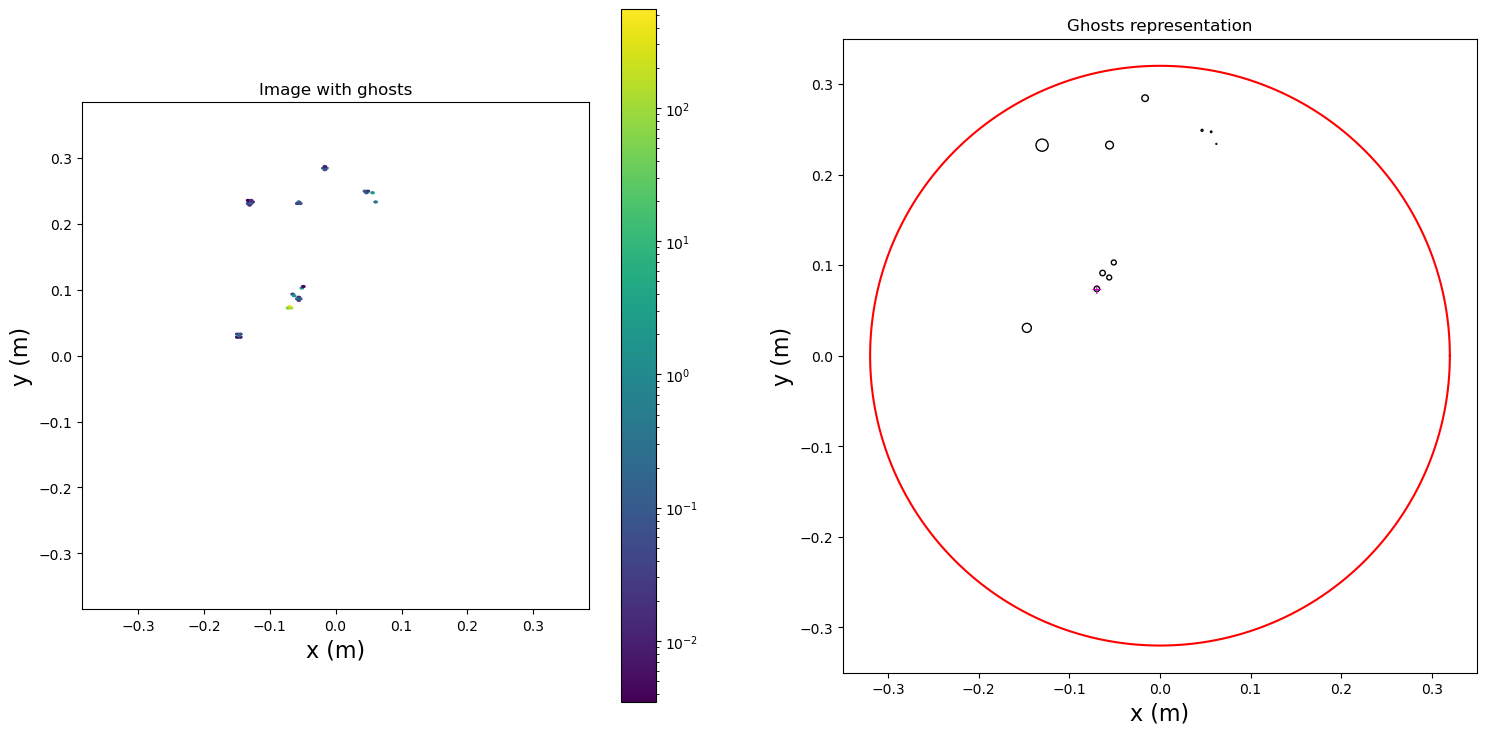

In [13]:
# Test beam - asymmetric, high angles, all ghosts inside
new_beam = copy.deepcopy(BEAM_CONFIG_0)
new_beam['x_offset'] = -0.3
new_beam['y_offset'] = -0.6

new_beam['x_euler'] = -17
new_beam['y_euler'] = +6

beam_test(telescope, new_beam)

## This is a better all ghosts inside configuration at "high" angle - BEAM_CONFIG_4

Direct path is number 15
  central impact point is (-0.019961, 0.134380)
  transmission is 0.7530

Maximum expected flux is 0.7530
Maximum bin content is 423.1669


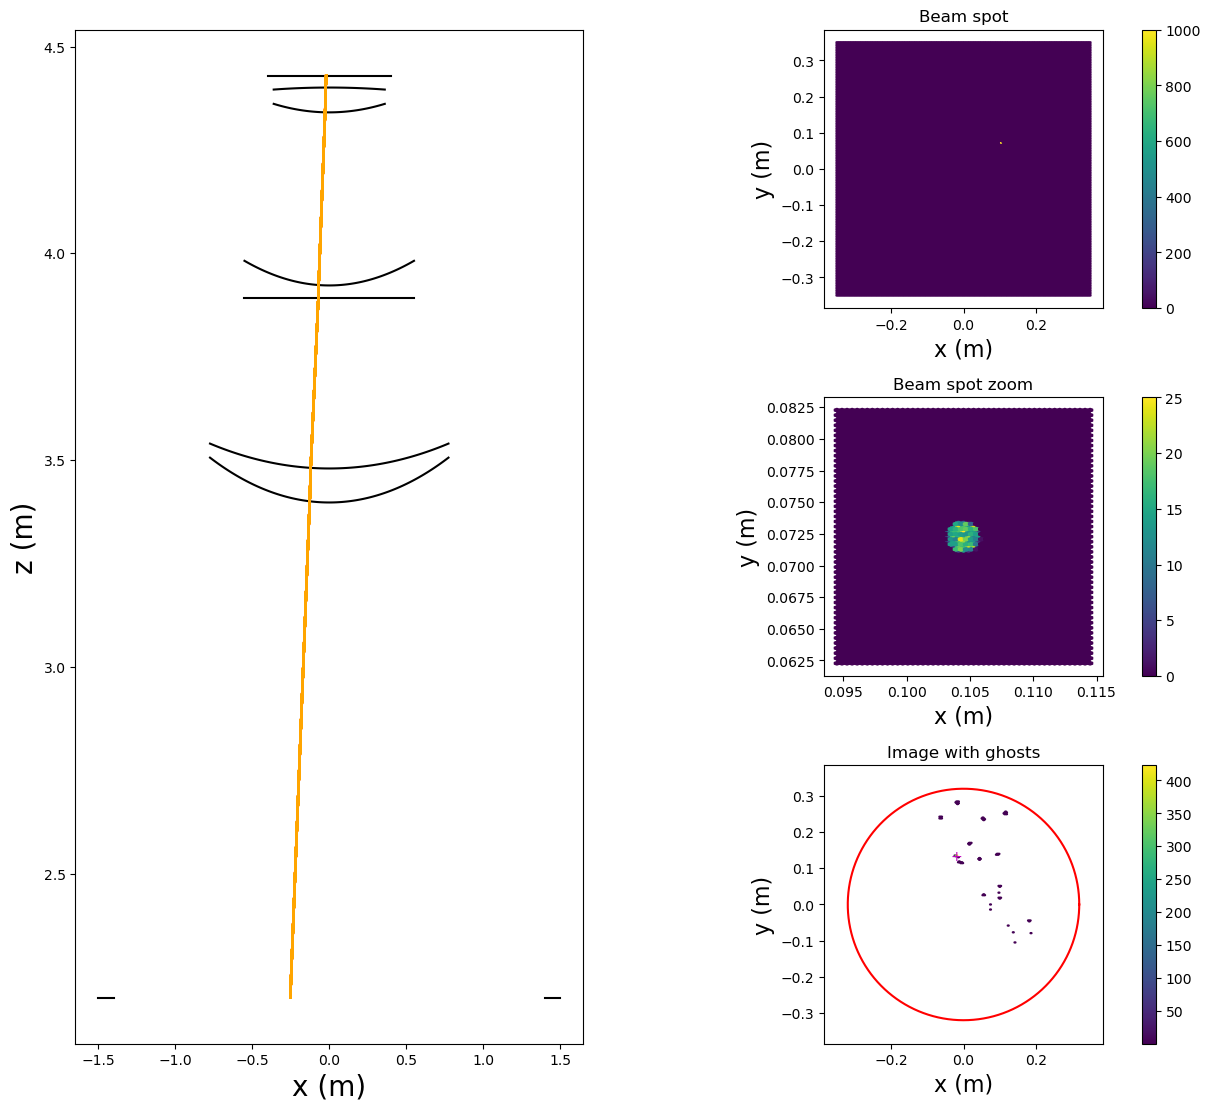

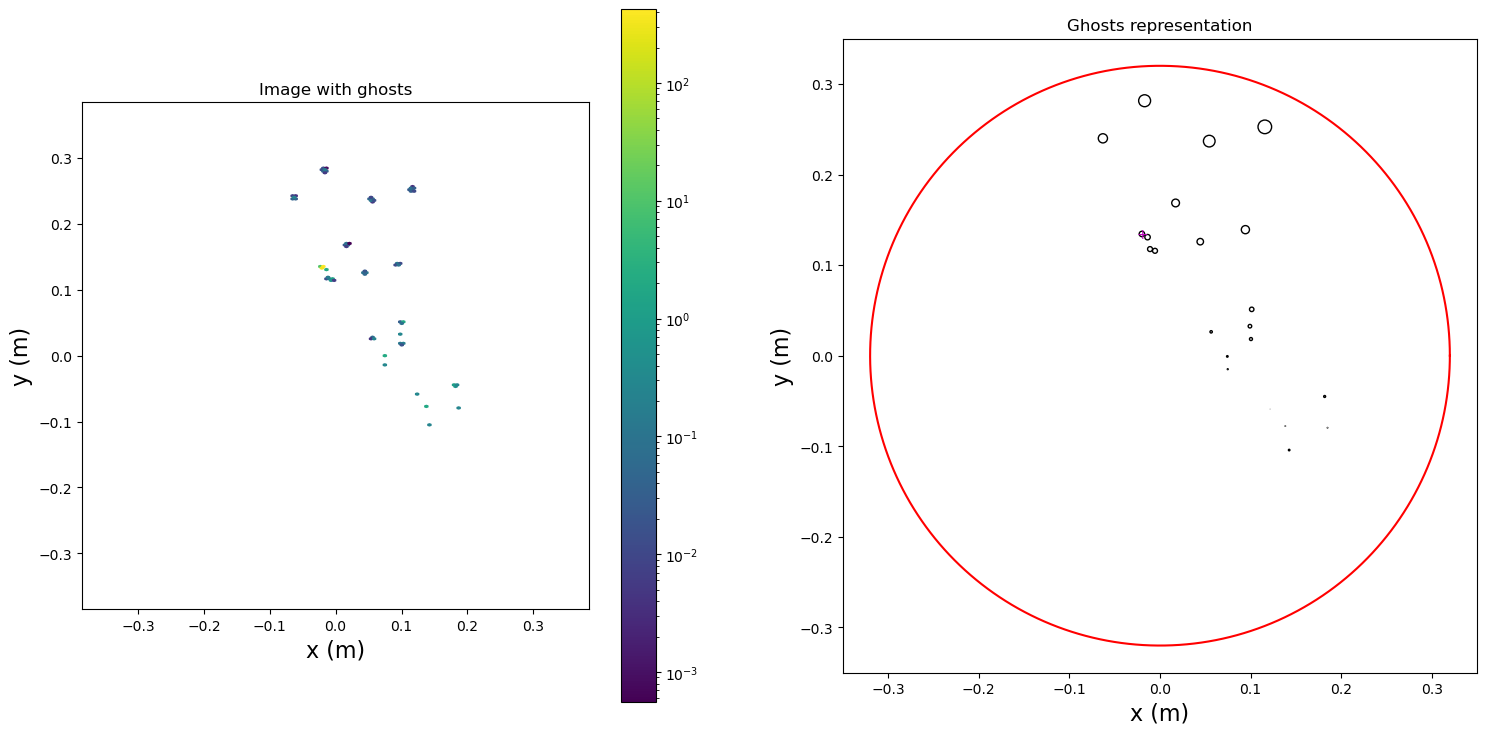

In [14]:
# Test beam - asymmetric, small angles, all ghosts inside
new_beam = copy.deepcopy(BEAM_CONFIG_0)
new_beam['x_offset'] = -0.25
new_beam['y_offset'] = 0.25

new_beam['x_euler'] = 3
new_beam['y_euler'] = 6

beam_test(telescope, new_beam)